In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Load libraries

In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt

In [7]:
dataset_path = "/content/drive/My Drive/Colab/Machine Learning/Datasets/Text Dataset/amazon_fine_food_review/reviews.csv"

In [8]:
data = pd.read_csv(dataset_path)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [11]:
data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


Since we are doing text classification, we can drop the other columns not related to food reviews. We will keep the score and text.

In [12]:
food_reviews_df = data[['Score', 'Text']].dropna()

In [13]:
food_reviews_df.head(5)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


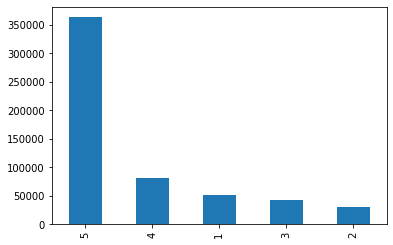

In [15]:
ax = food_reviews_df['Score'].value_counts().plot(kind='bar')

# To save a figure
# fig = ax.get_figure()
# fig.save_fig('score.png')

It seems like a 5-star rating is common for this restaurant.

To simplify our classification problem, we can split the ratings into 2. Ratings of 1-3 will be considered negative reviews while ratings of 4-5 will be considered positive. Hopefully, this will fix up some imbalanced classes problem.

In [16]:
food_reviews_df.loc[food_reviews_df['Score'] <= 3, 'Label'] = 0
food_reviews_df.loc[food_reviews_df['Score'] >= 4, 'Label'] = 1
food_reviews_df.head(5)

,Score,Text,Label
0,5,I have bought several of the Vitality canned d...,1.0
1,1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,4,This is a confection that has been around a fe...,1.0
3,2,If you are looking for the secret ingredient i...,0.0
4,5,Great taffy at a great price. There was a wid...,1.0


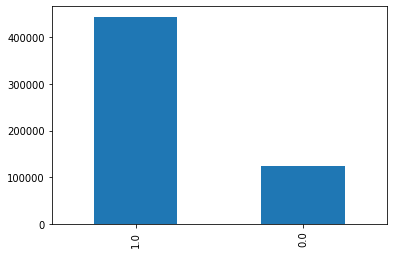

In [17]:
food_reviews_df['Label'].value_counts().plot(kind='bar')

From references, what they have done to tackle the imbalance classes problem is to sample a number of data from each class. Let's go with the same method for 8000 each.

In [97]:
train_pos_df = food_reviews_df[food_reviews_df['Label'] == 1][:8000]
train_neg_df = food_reviews_df[food_reviews_df['Label'] == 0][:8000]
train_df = train_pos_df.append(train_neg_df)
train_df.head(5)

,Score,Text,Label
0,5,I have bought several of the Vitality canned d...,1.0
2,4,This is a confection that has been around a fe...,1.0
4,5,Great taffy at a great price. There was a wid...,1.0
5,4,I got a wild hair for taffy and ordered this f...,1.0
6,5,This saltwater taffy had great flavors and was...,1.0


In [107]:
train_neg_df.head(5)

,Score,Text,Label
1,1,Product arrived labeled as Jumbo Salted Peanut...,0.0
3,2,If you are looking for the secret ingredient i...,0.0
12,1,My cats have been happily eating Felidae Plati...,0.0
16,2,I love eating them and they are good for watch...,0.0
26,1,"The candy is just red , No flavor . Just plan...",0.0


In [108]:
train_pos_df.head(5)

,Score,Text,Label
0,5,I have bought several of the Vitality canned d...,1.0
2,4,This is a confection that has been around a fe...,1.0
4,5,Great taffy at a great price. There was a wid...,1.0
5,4,I got a wild hair for taffy and ordered this f...,1.0
6,5,This saltwater taffy had great flavors and was...,1.0


Validation set:

In [98]:
val_pos_df = food_reviews_df[food_reviews_df['Label']==1][8000:10000]
val_neg_df = food_reviews_df[food_reviews_df['Label']==0][8000:10000]
val_df = val_pos_df.append(val_neg_df)
val_df.head(5)

,Score,Text,Label
10514,5,I am not generally a fan of Starbucks regular ...,1.0
10515,5,I was placed on a severly restricted sodium di...,1.0
10520,5,My husband had a stroke and needed no salt pro...,1.0
10521,5,I'm on a low sodium diet and this still has pl...,1.0
10523,5,I LOVE this soup! I have right sided heart fa...,1.0


# Enter spaCy

In [20]:
nlp = spacy.load("en_core_web_sm")

1. Tokenization of document(review texts)

In [21]:
sample = food_reviews_df['Text'][30]
print(sample)

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)


In [22]:
parsed = nlp(sample)
print(parsed)

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)


2. Tagging

In [23]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed):
  tokenized_text.loc[i, 'text'] = token.text
  tokenized_text.loc[i, 'lemma'] = token.lemma_
  tokenized_text.loc[i, 'pos'] = token.pos_
  tokenized_text.loc[i, 'tag'] = token.tag_
  tokenized_text.loc[i, 'dep'] = token.dep_
  tokenized_text.loc[i, 'shape'] = token.shape_
  tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
  tokenized_text.loc[i, 'is_stop'] = token.is_stop
  tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text.head(5)

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,I,-PRON-,PRON,PRP,nsubj,X,True,True,False
1,have,have,AUX,VBP,aux,xxxx,True,True,False
2,never,never,ADV,RB,neg,xxxx,True,True,False
3,been,be,AUX,VBN,ROOT,xxxx,True,True,False
4,a,a,DET,DT,det,x,True,True,False


3. Named Entity Recognition

spaCy automatically predicts the entity for each word.

- PERSON (People, include fictional)
- NORP (Nationalities/religious/political groups)
- FAC (Buildings/Airports/Highways/Bridges etc.)
- ORG (Companies/Agencies/Institutions etc.)
- GPE (Countries, cities, states)
- LOC (Non-GPE Locations, mountain ranges, bodies of water)
- PRODUCT (Objects, vehicles, food)
- EVENT (Named hurricanes, battles, wars, sports events, etc.)
- WORK_OF_ART (Titles of books, songs, etc.)
- LAW (Named documents made into laws)
- LANGUAGE (Any named language)
- DATE (Absolute/relative dates/periods)
- TIME (Times smaller than a day)
- PERCENT (Percentage, include %)
- MONEY (Monetary values, include unit)
- QUANTITY (Measurements, weight or distance)
- ORDINAL ("first", "second", etc.)
- CARDINAL (Numerals that do not fall under another type)

We can use spacy displacy to view directly in the sentence.

In [24]:
spacy.displacy.render(parsed, style='ent', jupyter=True)

4. Dependency Parsing

Subject/Predicate/Object

In [25]:
spacy.displacy.render(parsed, style='dep', jupyter=True, options={'distance': 140})

Processing noun chunks

In [26]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed.noun_chunks):
  noun_chunks_df.loc[i, 'text'] = chunk.text
  noun_chunks_df.loc[i, 'root'] = chunk.root
  noun_chunks_df.loc[i, 'root.text'] = chunk.root.text
  noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
  noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df.head(5)

,text,root,root.text,root.dep_,root.head.text
0,I,I,I,nsubj,been
1,a huge coffee fan,fan,fan,attr,been
2,my mother,mother,mother,nsubj,purchased
3,this little machine,machine,machine,dobj,purchased
4,me,me,me,dobj,talked


# SpaCy Text Categorizer

In [112]:
train_df['tuples'] = train_df.apply(lambda row: (row['Text'], row['Label']), axis=1)
train = train_df['tuples'].tolist()
train[-10]

('This is a good tasting beef jerky but a little too salty and some pieces were too oily.',
 0.0)

In [113]:
def load_data(limit=0, split=0.8):
  train_data = train
  np.random.shuffle(train_data)
  train_data = train_data[-limit:]
  texts, labels = zip(*train_data)
  cats = [{"POSITIVE": bool(y)} for y in labels]
  split = int(len(train_data)* split)
  return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
  docs = (tokenizer(text) for text in texts)
  tp = 1e-8
  fp = 1e-8
  fn = 1e-8
  tn = 1e-8

  for i, doc in enumerate(textcat.pipe(docs)):
    gold = cats[i]
    for label, score in doc.cats.items():
      if label not in gold:
        continue
      if score >= 0.5 and gold[label] >= 0.5:
        tp += 1
      elif score >= 0.5 and gold[label] < 0.5:
        fp += 1
      elif score < 0.5 and gold[label] < 0.5:
        tn += 1
      elif score < 0.5 and gold[label] >= 0.5:
        fn += 1
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f_score = 2 * (precision*recall) / (precision+recall)
  return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


In [114]:
n_texts = 8000
n_iter = 10

In [115]:
nlp = spacy.load("en_core_web_sm")
if 'textcat' not in nlp.pipe_names:
  textcat = nlp.create_pipe('textcat')
  nlp.add_pipe(textcat, last=True)
  textcat = nlp.get_pipe('textcat')
else:
  textcat = nlp.get_pipe('textcat')

textcat.add_label('POSITIVE')


1

In [116]:
# Load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)".format(n_texts, len(train_texts), len(dev_texts)))

train_data = list(zip(train_texts, [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 8000 examples (6400 training, 1600 evaluation)


Train model

In [117]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']

with nlp.disable_pipes(*other_pipes):
  optimizer = nlp.begin_training()
  print("Training the model...")
  print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format('LOSS', 'PRE', 'REC', 'F1'))

  for i in range(n_iter):
    losses = {}
    batches = minibatch(train_data, size=compounding(4., 32., 1.001))

    for batch in batches:
      texts, annotations = zip(*batch)
      nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)

    with textcat.model.use_params(optimizer.averages):
      scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
      print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(losses['textcat'], scores['textcat_p'], scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	 PRE 	 REC 	 F1  
8.967	0.764	0.799	0.781
5.083	0.831	0.847	0.839
3.623	0.844	0.842	0.843
2.668	0.856	0.837	0.846
1.871	0.839	0.851	0.845
1.486	0.835	0.863	0.849
1.193	0.847	0.857	0.852
0.945	0.841	0.851	0.846
0.867	0.842	0.854	0.848
0.790	0.831	0.851	0.840


In [118]:
print("Train data: ", train_data[0])
texts, labels = zip(*train_data)
print("Text: ", texts[0])
print("Label: ", labels[0])

Train data:  ('The fortune cookies were shipped immediately and were packed well, i.e. none arrived broken.  The cookie was delicious and the fortunes were classic chinese (and not the modern version).', {'cats': {'POSITIVE': True}})
Text:  The fortune cookies were shipped immediately and were packed well, i.e. none arrived broken.  The cookie was delicious and the fortunes were classic chinese (and not the modern version).
Label:  {'cats': {'POSITIVE': True}}


Test the model

In [119]:
sample = "Probably one of the worst jerky products I've ever tasted. It was almost gelatinous in texture and waxy. I think this is the result of being over tenderized. Perhaps this is a good product for those with dental problems or dentures, but for others, you may want to stick to another jerky brand."
doc = nlp(sample)
print(doc.cats)

{'POSITIVE': 0.00371951493434608}


In [120]:
sample = 'This tea is fun to watch as the flower expands in the water. Very smooth taste and can be used again and again in the same day. If you love tea, you gotta try these "flowering teas"'
doc = nlp(sample)
print(doc.cats)

{'POSITIVE': 0.9988954067230225}
